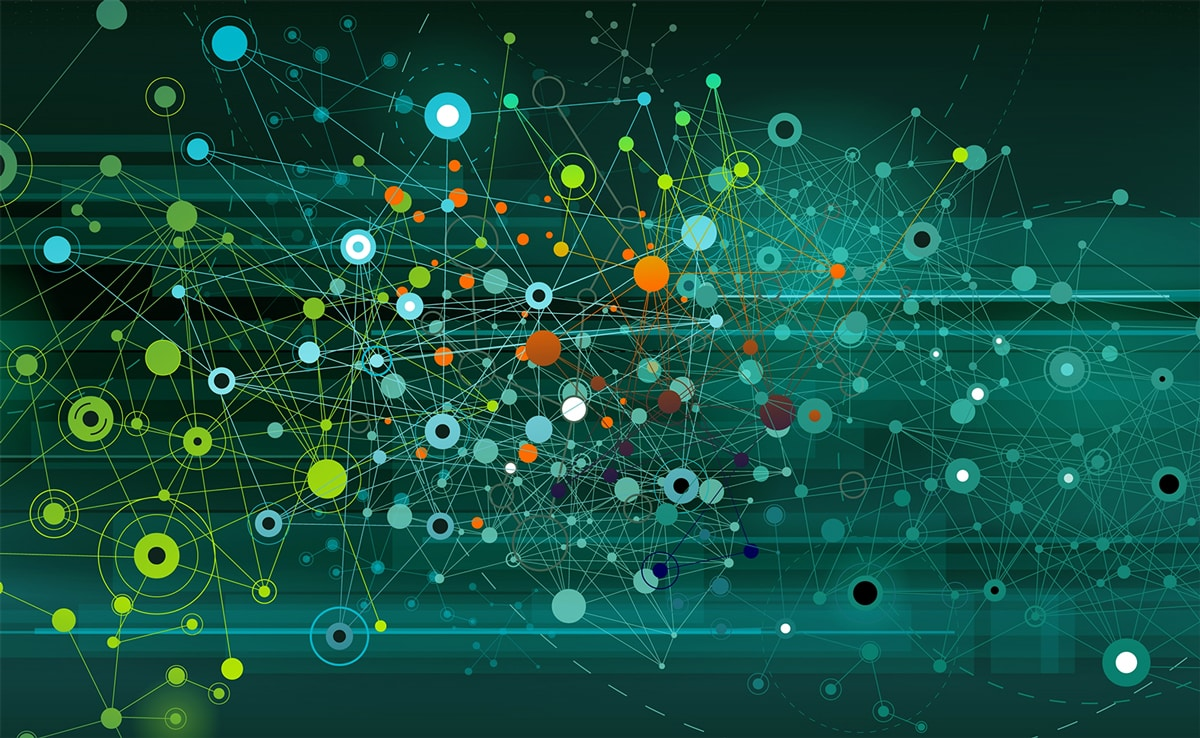
# Livrable 2

## Débruitage

### Groupe de projet 1 :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>

### Introduction

A la suite de notre premier livrable de classification binaire, ce second livrable se concentre sur la réalisation d'une phase de prétraitement de l'image de nos différents jeux de données.

Dans un premier temps, ce livrable présente une méthode pour générer un dataset d'images bruitées puis l'implémentation d'un autoencodeur capable de regénérer des images de bonnes qualitées. Dans ce cas, les labels sont les images elles-mêmes.



## Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [1]:
import os
import random
import datetime
import pathlib
import configuration
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorboard.plugins.hparams import api as hp
from skimage.util import random_noise
%matplotlib inline

data_dir = configuration.data_dir

## Datasets

Le script qui suit utilise toutes les images du dataset original pour générer un dataset équivalent d'image bruitée.

In [2]:
Comment this if you are sure that you want to generate noisy dataset

for file in os.listdir(data_dir+"/clean"):
    # Load the image
    image = cv2.imread(os.path.join(data_dir+"/clean",file))
    if image is not None:
        # Add salt-and-pepper noise to the image
        noise = random_noise(image, mode='s&p', amount=0.03+(random.random()*0.5))

        # The above function returns a floating-point image in the range [0, 1]
        # so need to change it to 'uint8' with range [0,255]
        noise = np.array(255 * noise, dtype=np.uint8)
        cv2.imwrite(os.path.join(data_dir+"/noise",file),noise)
#break #Uncomment to test the noisification on the first image only

SyntaxError: invalid syntax (<ipython-input-2-4f9f873052b0>, line 1)

Le script qui suit charge le dataset tout en appliquant une pipeline dessus pour unifier le format des données. Le pipeline consiste à redimensionner les images selon les variables ``ìmage_h`` et ``image_w`` et à passer les valeurs, qui sont originelement entre 0 et 255, entre 0 et 1.
Nous chargeons seulement 200 éléments dans le dataset pour permettre une execution rapide et moins coûteuse en ressources.

In [4]:
image_h = 304
image_w = 304
batch_s = 8

validation_threshold=0.2

valid_images = [".jpg",".gif",".png"]

clean_set = []
noisy_set = []

clean_files=os.listdir(data_dir+"/clean")
random.shuffle(clean_files)
# we are loading only 200 image to speed up the process
for file in clean_files[:200]:
    ext = os.path.splitext(file)[1]
    if ext.lower() not in valid_images or not os.path.isfile(os.path.join(data_dir+"/noise",file)) :
        continue
    clean_img=cv2.imread(os.path.join(data_dir+"/clean",file))
    clean_img=cv2.resize(clean_img, (image_h, image_w))
    clean_img=clean_img.astype('float32') / 255.
    
    noisy_img=cv2.imread(os.path.join(data_dir+"/noise",file))
    noisy_img=cv2.resize(noisy_img, (image_h, image_w))
    noisy_img=noisy_img.astype('float32') / 255.
    clean_set.append(clean_img)
    noisy_set.append(noisy_img)
clean_set = np.array(clean_set, dtype=object)
noisy_set = np.array(noisy_set, dtype=object)

split_index=int(noisy_set.shape[0]*(1-validation_threshold))

(clean_train_set, clean_test_set)=np.split(clean_set, [split_index])
(noisy_train_set, noisy_test_set)=np.split(noisy_set, [split_index])

print("Found {:d} clean files, {:d} train / {:d} test".format(clean_set.shape[0], clean_train_set.shape[0], clean_test_set.shape[0]))
print("Found {:d} noisy files, {:d} train / {:d} test".format(noisy_set.shape[0], noisy_train_set.shape[0], noisy_test_set.shape[0]))

Found 200 clean files, 160 train / 40 test
Found 200 noisy files, 160 train / 40 test


## Affichage

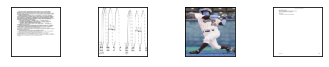

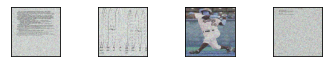

In [5]:
def display_image(X, n):
    plt.figure(figsize=(6, 2))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].astype('float32'))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(clean_train_set, n=4)
display_image(noisy_train_set, n=4)

On peut observer les images originales sur la première ligne et les images bruitées correspondantes en dessous. Pour l'entrainement, les labels sont les images elles-mêmes.

## Construction du modèle
Pour réaliser ce modèle nous avons créé une architecture reposant sur plusieurs couches :

- Une layers Input
- Plusieurs couches en fonction du paramètre ``filters`` (encodeur) :
    - Une layers Conv2D
    - Une layers MaxPooling2D
- Plusieurs couches en fonction du paramètre ``filters`` (décodeur) :
    - Une layers Conv2D
    - Une layers UpSampling2D
- Une layers Conv2D


In [6]:
def build_autoencoder(height, width, depth, filters=(32, 64)):
    # initialize the input shape to be "channels last" along with
    # the channels dimension itself
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    # define the input to the encoder
    inputs = layers.Input(shape=inputShape)
    x = inputs
    # loop over the number of filters
    for f in filters:
        # apply a CONV => MAX_POOLING
        x = layers.Conv2D(f, (3, 3), activation='relu', padding="same")(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
        # apply a CONV => UP_SAMPLING
        x = layers.Conv2D(f, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # our autoencoder is the encoder + decoder
    autoencoder = keras.models.Model(inputs, x,
        name="autoencoder")
    # return a 2-tuple of the input and autoencoder
    return (inputs, autoencoder)


(encoder_inputs, autoencoder) = build_autoencoder(image_h, image_w, 3, filters=(16, 32, 64))

# Model summary
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 304, 304, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 152, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 76, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 64)        

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les modèles à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [7]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_autoencoder_{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='min')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
})

### Entrainement du modèle

Nous compilons notre modèle avec l'optimiseur ``adam`` et nous récupérons la loss à l'aide de la ``binary_crossentropy``.

In [8]:
# Compile the model
autoencoder.compile(optimizer="adam",loss= 'binary_crossentropy')

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5588
Epoch 00001: val_loss improved from inf to 0.42505, saving model to training/cp_autoencoder_01.ckpt
20/20 [==============================] - 5s 55ms/step - loss: 0.5600 - val_loss: 0.4250
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4589
Epoch 00002: val_loss improved from 0.42505 to 0.39162, saving model to training/cp_autoencoder_02.ckpt
20/20 [==============================] - 1s 43ms/step - loss: 0.4602 - val_loss: 0.3916
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4257
Epoch 00003: val_loss did not improve from 0.39162
20/20 [==============================] - 1s 41ms/step - loss: 0.4227 - val_loss: 0.3965
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4207
Epoch 00004: val_loss improved from 0.39162 to 0.38630, saving model to training/cp_autoencoder_04.ckpt
20/20 [==============================] - 1s 44ms/step - loss: 0.4231 - va

Epoch 72/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3507
Epoch 00072: val_loss did not improve from 0.32725
20/20 [==============================] - 1s 41ms/step - loss: 0.3505 - val_loss: 0.3276
Epoch 73/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3506
Epoch 00073: val_loss improved from 0.32725 to 0.32688, saving model to training/cp_autoencoder_73.ckpt
20/20 [==============================] - 1s 43ms/step - loss: 0.3477 - val_loss: 0.3269
Epoch 74/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3536
Epoch 00074: val_loss did not improve from 0.32688
20/20 [==============================] - 1s 41ms/step - loss: 0.3520 - val_loss: 0.3362
Epoch 75/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3552
Epoch 00075: val_loss did not improve from 0.32688
20/20 [==============================] - 1s 41ms/step - loss: 0.3531 - val_loss: 0.3272
Epoch 76/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3507
Epoch 

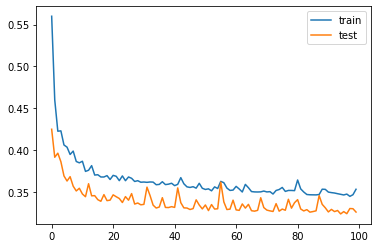

In [9]:
epochs=100

# Run the model
history = autoencoder.fit(tf.convert_to_tensor(noisy_train_set, dtype=tf.float32), tf.convert_to_tensor(clean_train_set, dtype=tf.float32),
                          epochs=epochs, batch_size=batch_s,
                          shuffle=True,
                          validation_data=(tf.convert_to_tensor(noisy_test_set, dtype=tf.float32), tf.convert_to_tensor(clean_test_set, dtype=tf.float32)),
                          callbacks=[cp_callback,tensorboard_callback])
 

# Save the model
save_path = "checkpoints/autoencoder.h5"
autoencoder.save_weights(save_path)

# Display training and validation loss Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot( history.history['loss'],
         label='train')
plt.plot( history.history['val_loss'],
         label='test')
plt.legend()

Nous pouvons observer sur le graphique précédent une diminution de la loss au fil des epochs pour le jeu d'entrainement et aussi pour le jeu de test, ce qui montre que notre modèle apprend des choses.

Le code qui suit va utiliser notre modèle entrainé pour enlever le bruit d'images bruitées passées en paramètres.

In [10]:
decoded_imgs = autoencoder.predict(tf.convert_to_tensor(noisy_test_set, dtype=tf.float32))

In [11]:
imgs_diff_clean_x_decoded = np.greater(np.subtract(clean_test_set.astype(float),decoded_imgs.astype(float)),0.2)

La première ligne correspond à la sortie du modèle, la seconde ligne correspond à l'image bruitée passée en entrée et la troisième ligne correspond à l'image original et la dernière ligne correspond à la différence supérieur à 0.2 entre l'image original et l'image en sortie du modèle.

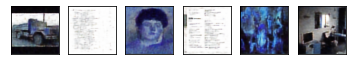

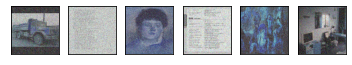

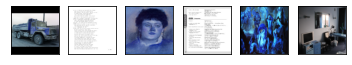

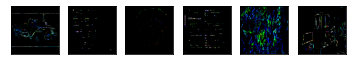

In [12]:
display_image(decoded_imgs, 6)
display_image(noisy_test_set, 6)
display_image(clean_test_set, 6)
display_image(imgs_diff_clean_x_decoded, 6)

Dans la dernière ligne, un pixel noir signifie qu'il n'y a pas de différence entre le pixel original et le pixel en sortie du modèle neuronal. Un pixel "allumé" signifie qu'il y a une différence de valeur de plus de 0,2. On peut donc voir que notre modèle est très performant et que les différences, très légères, se situent sur les contours des objets.

In [18]:
!tensorboard dev upload --logdir ./logs \
  --name "Livrable 2 : Projet Datascience - Leyenda." \
  --description "Modèle autoencodeur de débruitage." \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/BNDVnxmnRomRKp0YlNjkgw/

[2022-01-05T10:05:19] Started scanning logdir.
[2022-01-05T10:05:22] Total uploaded: 300 scalars, 1400 tensors (1006.3 kB), 1 binary objects (63.3 kB)
[2022-01-05T10:05:22] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/BNDVnxmnRomRKp0YlNjkgw/


## Schématisation de notre modèle et explication des couches

In [13]:
tf.keras.utils.plot_model(
autoencoder, to_file='model_auto_encodeur.png', show_shapes=True, show_dtype=False,
show_layer_names=True, expand_nested=True, dpi=96
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Voici la schématisation de notre auto encodeur :

- Une layers Input
    - Plusieurs couches en fonction du paramètre filters (encodeur) :
        - Une layers Conv2D
        - Une layers MaxPooling2D
> L'encodeur prend les données de grande dimension et les compressent vers une plus petite dimension.

    - Plusieurs couches en fonction du paramètre filters (décodeur) :
        - Une layers Conv2D
        - Une layers UpSampling2D
        - Une layers Conv2D
>Le décodeur qui prend les données en petite dimension et les rétroprojette vers la plus grande dimension.

Voici une autre schématisation de notre autoencodeur :
![Autoencodeur](images/Autoencodeur.png)

## Analyse des résultats

Dans un premier temps, nous avons entrainer notre modèle avec un dataset de taille 100 et 100 epochs. Les courbes de loss pour l'entrainement et la test sont en dents de scies avec un minimum à 0.279 pour la validation.

![Courbes de loss pour 100 images et 100 epochs](images/loss_curves_autoencoder_100images_100epochs.png)

Dans un second temps, nous avons entrainer notre modèle avec un dataset de taille 200 et 100 epochs. Les courbes de loss pour l'entrainement et la test sont beaucoup plus lisses avec un minimum à 0.2020 pour la validation.

![Courbes de loss pour 100 images et 100 epochs](images/loss_curves_autoencoder_200images_100epochs.png)

Enfin nous avons décider de réduire le nombre d'epochs à 40 ainsi que d'augmenter la taille du dataset à 400.
![Courbes de loss pour 100 images et 100 epochs](images/autoencoder_40epochs_400images.png)
Ce dernier modèle nous présente les résultats les plus probants avec la courbe de perte la plus lisse.


## Analyse biais-variance

Grâce aux résultats obtenus ci-dessus on peut déduire les paramètres qui optimizent le mieux le compromis biais-variance.

Tout d'abord, pour des questions de rapidité, nous avons entrainé notre modèle avec seulement 100 images. Le biais était ainsi fort car le dataset n'était pas assez varié.
Le problème qui en découle est que ce modèle peut surévaluer certaine feature d'une image et donc mal réagir sur des photos qu'il ne connait pas.
De plus nous avions réalisé notre entrainement sur 100 epochs. On constate donc de l'overfitting autour de la 50 ème epoch avec l'oscillement de la courbe de loss.
En effet, le modèle ne progresse plus mais continu de faire évoluer et donc apprend par coeur notre dataset.

Ainsi le meilleur moyen d'obtenir un bon compris biais variance est de diminuer les epochs (à 40 pour notre cas) et augmenter le nombre d'images d'entrainement (passage de 100 à 400).
Dans ce cas présent, nous avons décidé de ne pas utiliser de technique de régularisation car l'apprentissage se fait de manière non supervisé.